In [1]:
pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import ast
from matplotlib import cm
import s3fs
import numpy as np
import matplotlib.colors as colors
import networkx as nx
from scipy.sparse import coo_matrix
from shapely.geometry import Point
from shapely.ops import unary_union
from shapely import wkt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from haversine import haversine

In [4]:
from script import epci_features

/home/onyxia/work/statapp/script.py:19: DtypeWarning: Columns (1,1687,1688) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:24: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:34: DtypeWarning: Columns (1,2,3,4,14,15,16,18,22,24,27,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mobpro_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:142: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  contours_comm["centroid"] = contours_comm.geometry.centroid
/home/onyxia/work/statapp/script.py:151: UserWarning: Geometry is in a geographic CRS. Results from 'centroid'

antully: (46.89232199838103, 4.402852764409862)
le tremblay-omonville: (49.12081156432765, 0.9143802127565656)
vaux-lès-mouzon: (49.60389494206806, 5.136483053287144)
anchenoncourt-et-chazel: (47.8616809003776, 6.11534440434135)
culoz-béon: (45.85633732729717, 5.772905566192263)
domèvre-sur-avière: (48.22223470040439, 6.388423941842605)
bernoy-le-château: (49.32120314158208, 3.3070156677330558)
videcosville: (49.566672646936, -1.3714795795608266)
saint-agrève: (45.00542393638767, 4.413096930429594)
le bourg-d'oisans: (45.0340588974907, 6.032836629436181)


In [6]:
from script import df_mobpro_brut, arr_marseille, arr_paris, arr_lyon, contours_comm, transport_dict, contours_comm, flux, plot_flux_gradient, plot_flux_gradient_zoom, coord_villes
from script import df_dossier_complet_brut, mairies, df_epci_contours

# Calculs des distances des trajets dans la base mobpro

In [7]:
mairies[['lat', 'lon']] = mairies['Coordonnées'].str.split(',', expand=True).astype(float)
mairies_unique = mairies.drop_duplicates(subset='Code INSEE')

# Calculer le trajet interne
def approx_internal_distance(geom):
    bounds = geom.bounds  # (minx, miny, maxx, maxy)
    point_min = (bounds[1], bounds[0])  # (lat_min, lon_min)
    point_max = (bounds[3], bounds[2])  # (lat_max, lon_max)
    return haversine(point_min, point_max)

contours_comm['distance_intra'] = contours_comm['geometry'].apply(approx_internal_distance)/2 # On divise par 2 la diag pour les intra
distance_intra_dict = contours_comm.set_index('INSEE_COM')['distance_intra'].to_dict() # Dictionnaire des distances intra

# Calculer les trajets entre villes
mairies_unique = mairies.drop_duplicates(subset='Code INSEE') # Garder une seule mairie pour chaque ville
coords_mairies = mairies_unique.set_index('Code INSEE')[['lat', 'lon']].to_dict('index') 

# Fonction pour calculer la distance
def calculer_distance(code_depart, code_arrivee):
    if code_depart == code_arrivee:
        # Trajet intra-communal
        return distance_intra_dict.get(code_depart, 3.0)  # Fallback 3km si pas trouvé
    else:
        # Trajet intercommunal
        coords_depart = coords_mairies.get(code_depart)
        coords_arrivee = coords_mairies.get(code_arrivee)
        
        if coords_depart is None or coords_arrivee is None:
            return None  # Impossible de calculer (missing coords)
        
        return haversine((coords_depart['lat'], coords_depart['lon']),
                         (coords_arrivee['lat'], coords_arrivee['lon']))

df_mobpro_brut['distance_km'] = df_mobpro_brut.apply(
    lambda row: calculer_distance(row['COMMUNE'], row['DCLT']),
    axis=1)


In [8]:
df_mobpro_brut.sample()

,Unnamed: 0,COMMUNE,ARM,DCFLT,DCLT,AGEREVQ,CS1,DEROU,DIPL,EMPL,...,STAT,STOCD,TP,TRANS,TYPL,TYPMR,VOIT,TRANS_LABEL,CS_LABEL,distance_km
5335681,5335681,75114,75114,99999,75108,25,6,Z,14,16,...,10,22,1,6,2,11,0,Transports en commun,Ouvriers,5.040798


# Obtention du dataframe EPCI et ses features

In [9]:
"""OBTENTION DE gdf_epci_metropole IGNORANT LES EPCI HORS FRANCE METROPOLITAINE"""

def est_metropole(liste_departements):
    """
    Exclut les DOM-TOM et la Corse, ne conserve que la métropole.
    """
    if isinstance(liste_departements, str):
        try:
            liste_departements = ast.literal_eval(liste_departements)
        except Exception:
            return False  # La chaîne n'était pas une liste valide

    # Filtrage : ignorer les départements trop longs
    liste_departements = [str(dep).strip() for dep in liste_departements if len(str(dep).strip()) <= 3]

    for dep in liste_departements:
        # Exclure les codes contenant des lettres (ex: 2A ou 2B pour la Corse)
        if any(c.isalpha() for c in dep):
            return False

        try:
            if int(dep) >= 970:
                return False
        except ValueError:
            return False  # On exclut si ce n'est pas un entier valide

    return True


In [10]:
gdf_epci_metropole = df_epci_contours[df_epci_contours['INSEE_DEP'].apply(est_metropole)]

In [33]:
# Convertir geometry de chaine de caractère à géométries spatiales
def convert_if_string(geom):
    if isinstance(geom, str):
        return wkt.loads(geom)
    return geom


In [ ]:
gdf_epci_metropole['geometry'] = gdf_epci_metropole['geometry'].apply(convert_if_string)

# Créer un GeoDataFrame
gdf_epci_metropole = gpd.GeoDataFrame(gdf_epci_metropole, geometry='geometry')

# Tracer les contours des EPCI
fig, ax = plt.subplots(figsize=(10, 10))
gdf_epci_metropole.plot(ax=ax, edgecolor='black', facecolor='none')
plt.title('Contours des EPCI')
plt.axis('off')
plt.show()

In [ ]:
gdf_epci_metropole.sample()

,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,Nb actifs occupés en 2021,geometry
390,390,200067288,"['Salies-de-Béarn', 'Escos', 'Tabaille-Usquain...","['64499', '64205', '64531', '64242', '64474', ...","['64', '64', '64', '64', '64', '64', '64', '64...",17403.0,1199.561759,7962.28049,5128.064106,"POLYGON ((382836.3 6257254.2, 382829.4 6257253..."


In [ ]:
# Fonction pour convertir les chaînes de caractères en listes
def convert_to_list(value):
    if isinstance(value, str):
        # Supprime les caractères indésirables et divise la chaîne
        cleaned = value.replace('[', '').replace(']', '').replace("'", '').replace('"', '')
        # Divise la chaîne en éléments individuels
        items = [item.strip() for item in cleaned.split(',') if item.strip()]
        return items
    elif isinstance(value, list):
        return value
    return []

# 2. Définir les tranches de distances
distance_bins = [0, 10, 20, 30, 40, 50, float('inf')]
distance_labels = ['<10km', '<20km', '<30km', '<40km', '<50km', '>50km']

# 3. Définir les catégories de transport
transport_categories = {
    'vert': [1, 2, 3],
    'jaune': [6],
    'rouge': [4, 5]
}

# Créer un dictionnaire pour stocker les résultats
results = {}

In [ ]:
# 1. Convertir les colonnes de codes INSEE en listes
print("Conversion des codes INSEE en listes...")
gdf_epci_metropole['INSEE_COM_list'] = gdf_epci_metropole['INSEE_COM'].apply(convert_to_list)
gdf_epci_metropole['INSEE_DEP_list'] = gdf_epci_metropole['INSEE_DEP'].apply(convert_to_list)

Conversion des codes INSEE en listes...


## Calcul des features (+1h)

In [ ]:
'''
from tqdm import tqdm

# Boucle sur chaque EPCI avec barre de progression
print("Calcul des statistiques par EPCI...")
for idx, epci_row in tqdm(gdf_epci_metropole.iterrows(), total=gdf_epci_metropole.shape[0], desc="Traitement des EPCI"):
    epci_communes = set(epci_row['INSEE_COM_list'])
    epci_code = epci_row['SIREN_EPCI']
    
    results[epci_code] = {}
    
    for transport_name, transport_codes in transport_categories.items():
        transport_data = df_mobpro_brut[df_mobpro_brut['TRANS'].isin(transport_codes)]
        
        entrants = transport_data[
            (~transport_data['DCLT'].isin(epci_communes)) & 
            (transport_data['COMMUNE'].isin(epci_communes))
        ]
        sortants = transport_data[
            (transport_data['DCLT'].isin(epci_communes)) & 
            (~transport_data['COMMUNE'].isin(epci_communes))
        ]
        internes = transport_data[
            (transport_data['DCLT'].isin(epci_communes)) & 
            (transport_data['COMMUNE'].isin(epci_communes))
        ]
        
        for i, (lower, upper) in enumerate(zip(distance_bins[:-1], distance_bins[1:])):
            label = distance_labels[i]
            
            entrants_bin = entrants[(entrants['distance_km'] > lower) & (entrants['distance_km'] <= upper)]
            results[epci_code][f'nb_entrant_{label}_{transport_name}'] = entrants_bin['IPONDI'].sum()
            results[epci_code][f'distance_entrant_{label}_{transport_name}'] = (
                (entrants_bin['distance_km'] * entrants_bin['IPONDI']).sum() / entrants_bin['IPONDI'].sum()
                if entrants_bin['IPONDI'].sum() > 0 else 0
            )
            
            sortants_bin = sortants[(sortants['distance_km'] > lower) & (sortants['distance_km'] <= upper)]
            results[epci_code][f'nb_sortant_{label}_{transport_name}'] = sortants_bin['IPONDI'].sum()
            results[epci_code][f'distance_sortant_{label}_{transport_name}'] = (
                (sortants_bin['distance_km'] * sortants_bin['IPONDI']).sum() / sortants_bin['IPONDI'].sum()
                if sortants_bin['IPONDI'].sum() > 0 else 0
            )
        
        results[epci_code][f'nb_intra_{transport_name}'] = internes['IPONDI'].sum()
        results[epci_code][f'distance_intra_{transport_name}'] = (
            (internes['distance_km'] * internes['IPONDI']).sum() / internes['IPONDI'].sum()
            if internes['IPONDI'].sum() > 0 else 0
        )
'''

Calcul des statistiques par EPCI...


Traitement des EPCI: 100%|██████████| 1225/1225 [1:18:15<00:00,  3.83s/it]


In [ ]:
from tqdm import tqdm
# Boucle sur chaque EPCI avec barre de progression
print("Calcul des statistiques par EPCI...")
for idx, epci_row in tqdm(gdf_epci_metropole.iterrows(), total=gdf_epci_metropole.shape[0], desc="Traitement des EPCI"):
    epci_communes = set(epci_row['INSEE_COM_list'])
    epci_code = epci_row['SIREN_EPCI']
    results[epci_code] = {}
    
    # Renommage des étiquettes de distance en utilisant le format 10<x<20km
    # On suppose que distance_labels est défini ailleurs dans votre code
    new_distance_labels = []
    for i, (lower, upper) in enumerate(zip(distance_bins[:-1], distance_bins[1:])):
        if i == 0:  # Premier intervalle (probablement <20km)
            new_label = f"<{upper}km"
        else:
            new_label = f"{lower}<x<{upper}km"
        new_distance_labels.append(new_label)
    
    for transport_name, transport_codes in transport_categories.items():
        transport_data = df_mobpro_brut[df_mobpro_brut['TRANS'].isin(transport_codes)]
        entrants = transport_data[
            (~transport_data['DCLT'].isin(epci_communes)) &
            (transport_data['COMMUNE'].isin(epci_communes))
        ]
        sortants = transport_data[
            (transport_data['DCLT'].isin(epci_communes)) &
            (~transport_data['COMMUNE'].isin(epci_communes))
        ]
        internes = transport_data[
            (transport_data['DCLT'].isin(epci_communes)) &
            (transport_data['COMMUNE'].isin(epci_communes))
        ]
        
        for i, (lower, upper) in enumerate(zip(distance_bins[:-1], distance_bins[1:])):
            new_label = new_distance_labels[i]
            
            # Traitement des flux entrants
            entrants_bin = entrants[(entrants['distance_km'] > lower) & (entrants['distance_km'] <= upper)]
            results[epci_code][f'nb_entrant_{new_label}_{transport_name}'] = entrants_bin['IPONDI'].sum()
            # Calcul de la distance totale au lieu de la moyenne
            results[epci_code][f'distance_entrant_{new_label}_{transport_name}'] = (
                (entrants_bin['distance_km'] * entrants_bin['IPONDI']).sum()  # Enlève la division pour avoir la distance totale
            )
            
            # Traitement des flux sortants
            sortants_bin = sortants[(sortants['distance_km'] > lower) & (sortants['distance_km'] <= upper)]
            results[epci_code][f'nb_sortant_{new_label}_{transport_name}'] = sortants_bin['IPONDI'].sum()
            # Calcul de la distance totale au lieu de la moyenne
            results[epci_code][f'distance_sortant_{new_label}_{transport_name}'] = (
                (sortants_bin['distance_km'] * sortants_bin['IPONDI']).sum()  # Enlève la division pour avoir la distance totale
            )
        
        # Traitement des flux internes (pas d'intervalles de distance pour ceux-ci)
        results[epci_code][f'nb_intra_{transport_name}'] = internes['IPONDI'].sum()
        # Calcul de la distance totale au lieu de la moyenne
        results[epci_code][f'distance_intra_{transport_name}'] = (
            (internes['distance_km'] * internes['IPONDI']).sum()  # Enlève la division pour avoir la distance totale
        )

Calcul des statistiques par EPCI...


Traitement des EPCI:   0%|          | 0/1225 [00:01<?, ?it/s]


KeyError: 'distance_km'

In [ ]:

# Convertir les résultats en DataFrame
print("Conversion des résultats en DataFrame...")
results_df = pd.DataFrame.from_dict(results, orient='index')

# Joindre les résultats au GeoDataFrame original
print("Jointure des résultats au GeoDataFrame...")
gdf_epci_metropole_enrichi = gdf_epci_metropole.merge(results_df, left_on='SIREN_EPCI', right_index=True, how='left')

# Afficher un aperçu des colonnes ajoutées
print("\nColonnes ajoutées:")
new_columns = [col for col in gdf_epci_metropole_enrichi.columns if col not in gdf_epci_metropole.columns]
print(f"Nombre de nouvelles colonnes: {len(new_columns)}")
print(new_columns[:10])  # Afficher les 10 premières nouvelles colonnes

print("\nAperçu du GeoDataFrame enrichi:")
print(gdf_epci_metropole_enrichi.head())


Conversion des résultats en DataFrame...
Jointure des résultats au GeoDataFrame...

Colonnes ajoutées:
Nombre de nouvelles colonnes: 78
['nb_entrant_<10km_vert', 'distance_entrant_<10km_vert', 'nb_sortant_<10km_vert', 'distance_sortant_<10km_vert', 'nb_entrant_<20km_vert', 'distance_entrant_<20km_vert', 'nb_sortant_<20km_vert', 'distance_sortant_<20km_vert', 'nb_entrant_<30km_vert', 'distance_entrant_<30km_vert']

Aperçu du GeoDataFrame enrichi:
   Unnamed: 0 SIREN_EPCI                                                NOM  \
0           0  200000172  ['Marignier', 'Contamine-sur-Arve', 'Glières-V...   
1           1  200000438  ['Crossac', 'Pontchâteau', 'Sainte-Anne-sur-Br...   
2           2  200000545  ['Crancey', 'Saint-Hilaire-sous-Romilly', 'Rom...   
3           3  200000628  ['Lapalud', 'Mondragon', 'Mornas', 'Lamotte-du...   
4           4  200000800  ['Chaumont-sur-Tharonne', 'Chaon', 'Vouzon', '...   

                                           INSEE_COM  \
0  ['74164', '74087

In [ ]:
gdf_epci_metropole_enrichi.sample()

,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,Nb actifs occupés en 2021,geometry,...,nb_entrant_<50km_rouge,distance_entrant_<50km_rouge,nb_sortant_<50km_rouge,distance_sortant_<50km_rouge,nb_entrant_>50km_rouge,distance_entrant_>50km_rouge,nb_sortant_>50km_rouge,distance_sortant_>50km_rouge,nb_intra_rouge,distance_intra_rouge
0,0,200000172,"['Marignier', 'Contamine-sur-Arve', 'Glières-V...","['74164', '74087', '74212', '74312', '74049', ...","['74', '74', '74', '74', '74', '74', '74']",27218.0,2218.427898,11802.018216,12031.433753,"POLYGON ((967052.3 6556343.9, 967045.7 6556329...",...,23.424631,41.855623,98.852138,45.998058,103.969510,216.047856,271.156739,181.420870,3588.632912,5.668859
1,1,200000438,"['Crossac', 'Pontchâteau', 'Sainte-Anne-sur-Br...","['44050', '44129', '44152', '44098', '44068', ...","['44', '44', '44', '44', '44', '44', '44', '44...",35917.0,2756.235128,15784.280047,14384.550345,"POLYGON ((325044.8 6719783.3, 325064.2 6719753...",...,1102.793630,45.257024,253.071753,45.521902,490.328609,157.114357,187.438224,143.643734,4143.172699,7.481773
2,2,200000545,"['Crancey', 'Saint-Hilaire-sous-Romilly', 'Rom...","['10114', '10341', '10323', '10164', '10220', ...","['10', '10', '10', '10', '10', '10']",18739.0,874.965660,8665.218943,5446.249610,"POLYGON ((751763.4 6819199.7, 751729 6819176.1...",...,32.553518,44.753960,87.961210,44.483349,452.965644,132.967389,175.929027,134.837601,2352.085074,4.782090
3,3,200000628,"['Lapalud', 'Mondragon', 'Mornas', 'Lamotte-du...","['84064', '84078', '84083', '84063', '84019']","['84', '84', '84', '84', '84']",24224.0,1442.982297,10773.779439,7526.326339,"POLYGON ((841785.2 6347339.5, 841574.2 6347339...",...,85.004987,44.079470,104.088887,44.554021,293.441754,192.753391,229.911823,162.979680,3048.432489,5.904768
4,4,200000800,"['Chaumont-sur-Tharonne', 'Chaon', 'Vouzon', '...","['41046', '41036', '41296', '41161', '41106', ...","['41', '41', '41', '41', '41', '41']",10437.0,550.174086,4746.154398,3763.453777,"POLYGON ((631422.5 6721239, 631378 6721141.6, ...",...,151.569186,42.964703,73.995380,43.829028,130.487340,144.713486,138.297036,116.352574,1653.353772,7.436458


On a enregistré sur S3 ce dataframe final pour ne pas avoir à relancer le code à chaque fois en entier (car très long) et il s'appelle désormais epci_features

# Clustering 

In [6]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "williamolivier"
FILE_PATH_S3_DEP = f"{MY_BUCKET}/diffusion/epci_features_2.csv"
with fs.open(FILE_PATH_S3_DEP, "rb") as file_in_dep:
    epci_features_2 = pd.read_csv(file_in_dep)

In [7]:
pd.set_option("display.max_columns", None)

In [8]:
epci_features_2.head(1)

,Unnamed: 0.1,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,Nb actifs occupés en 2021,geometry,INSEE_COM_list,INSEE_DEP_list,nb_entrant_<10km_vert,distance_entrant_<10km_vert,nb_sortant_<10km_vert,distance_sortant_<10km_vert,nb_entrant_10<x<20km_vert,distance_entrant_10<x<20km_vert,nb_sortant_10<x<20km_vert,distance_sortant_10<x<20km_vert,nb_entrant_20<x<30km_vert,distance_entrant_20<x<30km_vert,nb_sortant_20<x<30km_vert,distance_sortant_20<x<30km_vert,nb_entrant_30<x<40km_vert,distance_entrant_30<x<40km_vert,nb_sortant_30<x<40km_vert,distance_sortant_30<x<40km_vert,nb_entrant_40<x<50km_vert,distance_entrant_40<x<50km_vert,nb_sortant_40<x<50km_vert,distance_sortant_40<x<50km_vert,nb_entrant_50<x<infkm_vert,distance_entrant_50<x<infkm_vert,nb_sortant_50<x<infkm_vert,distance_sortant_50<x<infkm_vert,nb_intra_vert,distance_intra_vert,nb_entrant_<10km_jaune,distance_entrant_<10km_jaune,nb_sortant_<10km_jaune,distance_sortant_<10km_jaune,nb_entrant_10<x<20km_jaune,distance_entrant_10<x<20km_jaune,nb_sortant_10<x<20km_jaune,distance_sortant_10<x<20km_jaune,nb_entrant_20<x<30km_jaune,distance_entrant_20<x<30km_jaune,nb_sortant_20<x<30km_jaune,distance_sortant_20<x<30km_jaune,nb_entrant_30<x<40km_jaune,distance_entrant_30<x<40km_jaune,nb_sortant_30<x<40km_jaune,distance_sortant_30<x<40km_jaune,nb_entrant_40<x<50km_jaune,distance_entrant_40<x<50km_jaune,nb_sortant_40<x<50km_jaune,distance_sortant_40<x<50km_jaune,nb_entrant_50<x<infkm_jaune,distance_entrant_50<x<infkm_jaune,nb_sortant_50<x<infkm_jaune,distance_sortant_50<x<infkm_jaune,nb_intra_jaune,distance_intra_jaune,nb_entrant_<10km_rouge,distance_entrant_<10km_rouge,nb_sortant_<10km_rouge,distance_sortant_<10km_rouge,nb_entrant_10<x<20km_rouge,distance_entrant_10<x<20km_rouge,nb_sortant_10<x<20km_rouge,distance_sortant_10<x<20km_rouge,nb_entrant_20<x<30km_rouge,distance_entrant_20<x<30km_rouge,nb_sortant_20<x<30km_rouge,distance_sortant_20<x<30km_rouge,nb_entrant_30<x<40km_rouge,distance_entrant_30<x<40km_rouge,nb_sortant_30<x<40km_rouge,distance_sortant_30<x<40km_rouge,nb_entrant_40<x<50km_rouge,distance_entrant_40<x<50km_rouge,nb_sortant_40<x<50km_rouge,distance_sortant_40<x<50km_rouge,nb_entrant_50<x<infkm_rouge,distance_entrant_50<x<infkm_rouge,nb_sortant_50<x<infkm_rouge,distance_sortant_50<x<infkm_rouge,nb_intra_rouge,distance_intra_rouge
0,0,0,200000172,"['Marignier', 'Contamine-sur-Arve', 'Glières-V...","['74164', '74087', '74212', '74312', '74049', ...","['74', '74', '74', '74', '74', '74', '74']",27218.0,2218.427898,11802.018216,12031.433753,"POLYGON ((967052.3000000003 6556343.899999995,...","['74164', '74087', '74212', '74312', '74049', ...","['74', '74', '74', '74', '74', '74', '74']",77.219203,515.203272,58.92494,396.113115,17.827159,272.637945,36.910116,495.395217,16.972383,407.038892,16.03281,394.767824,10.0,333.089285,1.056825,35.194974,3.297112,156.672697,3.353119,143.841099,20.44915,5920.470905,21.865226,7990.764584,1272.291641,6539.72572,21.056535,148.080724,124.006331,907.057666,51.215022,819.134176,90.609518,1155.532295,5.451053,127.696817,19.042561,448.252972,10.0,353.448619,0.0,0.0,0.0,0.0,0.0,0.0,38.358625,14517.567031,8.406093,2648.376646,34.596625,218.52791,2459.834459,17110.996835,3839.015611,25279.250588,2131.460637,31123.62187,2771.42265,38445.308691,600.469169,14614.358546,977.061184,24089.046477,181.257301,6193.220715,337.46789,11330.006979,23.424631,980.452533,98.852138,4547.006371,103.96951,22462.389658,271.156739,49193.491341,3588.632912,20343.455026


In [9]:
epci_features.head(1)

,Unnamed: 0.1,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,Nb actifs occupés en 2021,geometry,MONO_DEP,INSEE_COM_list,INSEE_DEP_list,nb_entrant_<10km_vert,distance_entrant_<10km_vert,nb_sortant_<10km_vert,distance_sortant_<10km_vert,nb_entrant_<20km_vert,distance_entrant_<20km_vert,nb_sortant_<20km_vert,distance_sortant_<20km_vert,nb_entrant_<30km_vert,distance_entrant_<30km_vert,nb_sortant_<30km_vert,distance_sortant_<30km_vert,nb_entrant_<40km_vert,distance_entrant_<40km_vert,nb_sortant_<40km_vert,distance_sortant_<40km_vert,nb_entrant_<50km_vert,distance_entrant_<50km_vert,nb_sortant_<50km_vert,distance_sortant_<50km_vert,nb_entrant_>50km_vert,distance_entrant_>50km_vert,nb_sortant_>50km_vert,distance_sortant_>50km_vert,nb_intra_vert,distance_intra_vert,nb_entrant_<10km_jaune,distance_entrant_<10km_jaune,nb_sortant_<10km_jaune,distance_sortant_<10km_jaune,nb_entrant_<20km_jaune,distance_entrant_<20km_jaune,nb_sortant_<20km_jaune,distance_sortant_<20km_jaune,nb_entrant_<30km_jaune,distance_entrant_<30km_jaune,nb_sortant_<30km_jaune,distance_sortant_<30km_jaune,nb_entrant_<40km_jaune,distance_entrant_<40km_jaune,nb_sortant_<40km_jaune,distance_sortant_<40km_jaune,nb_entrant_<50km_jaune,distance_entrant_<50km_jaune,nb_sortant_<50km_jaune,distance_sortant_<50km_jaune,nb_entrant_>50km_jaune,distance_entrant_>50km_jaune,nb_sortant_>50km_jaune,distance_sortant_>50km_jaune,nb_intra_jaune,distance_intra_jaune,nb_entrant_<10km_rouge,distance_entrant_<10km_rouge,nb_sortant_<10km_rouge,distance_sortant_<10km_rouge,nb_entrant_<20km_rouge,distance_entrant_<20km_rouge,nb_sortant_<20km_rouge,distance_sortant_<20km_rouge,nb_entrant_<30km_rouge,distance_entrant_<30km_rouge,nb_sortant_<30km_rouge,distance_sortant_<30km_rouge,nb_entrant_<40km_rouge,distance_entrant_<40km_rouge,nb_sortant_<40km_rouge,distance_sortant_<40km_rouge,nb_entrant_<50km_rouge,distance_entrant_<50km_rouge,nb_sortant_<50km_rouge,distance_sortant_<50km_rouge,nb_entrant_>50km_rouge,distance_entrant_>50km_rouge,nb_sortant_>50km_rouge,distance_sortant_>50km_rouge,nb_intra_rouge,distance_intra_rouge
0,0,0,200000172,"['Marignier', 'Contamine-sur-Arve', 'Glières-V...","['74164', '74087', '74212', '74312', '74049', ...","['74', '74', '74', '74', '74', '74', '74']",27218.0,2218.427898,11802.018216,12031.433753,"POLYGON ((967052.3000000003 6556343.899999995,...",True,"['74164', '74087', '74212', '74312', '74049', ...","['74', '74', '74', '74', '74', '74', '74']",77.219203,6.671958,58.92494,6.722334,17.827159,15.293404,36.910116,13.421665,16.972383,23.982425,16.03281,24.622498,10.0,33.308928,1.056825,33.302544,3.297112,47.518156,3.353119,42.897703,20.44915,289.521607,21.865226,365.455392,1272.291641,5.140115,21.056535,7.032531,124.006331,7.314608,51.215022,15.994022,90.609518,12.75288,5.451053,23.426082,19.042561,23.539531,10.0,35.344862,0.0,0.0,0.0,0.0,0.0,0.0,38.358625,378.469433,8.406093,315.054414,34.596625,6.316452,2459.834459,6.956158,3839.015611,6.584826,2131.460637,14.602016,2771.42265,13.872048,600.469169,24.338233,977.061184,24.654594,181.257301,34.168117,337.46789,33.573585,23.424631,41.855623,98.852138,45.998058,103.96951,216.047856,271.156739,181.42087,3588.632912,5.668859


In [13]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Ajout du ratio "sortant_sur_entrant"
print("Calcul du ratio sortant/entrant...")

# Identifier toutes les colonnes commençant par 'nb_entrant_' et 'nb_sortant_'
entrant_cols = [col for col in epci_features_2.columns if col.startswith('nb_entrant_')]
sortant_cols = [col for col in epci_features_2.columns if col.startswith('nb_sortant_')]

# Calculer la somme des flux entrants et sortants pour chaque EPCI
epci_features_2['total_entrants'] = epci_features_2[entrant_cols].sum(axis=1)
epci_features_2['total_sortants'] = epci_features_2[sortant_cols].sum(axis=1)

# Calculer le ratio sortant/entrant en évitant les divisions par zéro
epci_features_2['sortant_sur_entrant'] = np.where(
    epci_features_2['total_entrants'] > 0,
    epci_features_2['total_sortants'] / epci_features_2['total_entrants'],
    0  # Valeur par défaut si pas de flux entrants
)

# Paramètre pour le nombre de clusters
n_clusters = 6

# On sélectionne explicitement les features que l'on veut utiliser
print("Sélection des features pour le clustering...")

# 1. Toutes les variables commençant par 'nb_' ou 'distance_'
nb_cols = [col for col in epci_features_2.columns if col.startswith('nb_')]
distance_cols = [col for col in epci_features_2.columns if col.startswith('distance_')]

# 2. Ajouter spécifiquement 'Nb actifs occupés en 2021' et 'sortant_sur_entrant'
features_list = nb_cols + distance_cols + ['Nb actifs occupés en 2021', 'sortant_sur_entrant']

# Vérification que toutes les features sont présentes dans le dataframe
missing_features = [col for col in features_list if col not in epci_features_2.columns]
if missing_features:
    print(f"Attention: les features suivantes sont manquantes: {missing_features}")
    features_list = [col for col in features_list if col in epci_features_2.columns]

print(f"Nombre de features utilisées pour le clustering: {len(features_list)}")

# Sélection des données pour le k-means
print("Préparation des données pour k-means...")
df_kmeans = epci_features_2[features_list].copy()

# Gérer les valeurs manquantes si besoin
print("Vérification des valeurs manquantes...")
missing_values = df_kmeans.isnull().sum().sum()
if missing_values > 0:
    print(f"Remplacement de {missing_values} valeurs manquantes par 0")
    df_kmeans = df_kmeans.fillna(0)

# Standardisation des données (important pour k-means)
print("Standardisation des données...")
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_kmeans)

# Application de k-means avec k=7
print(f"Application de k-means avec {n_clusters} clusters...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(data_scaled)

# Ajouter les résultats du clustering au DataFrame original
epci_features_2['cluster'] = cluster_labels

# Analyse des clusters
print("Analyse des clusters...")
# Taille de chaque cluster
cluster_sizes = epci_features_2['cluster'].value_counts().sort_index()
print("Nombre d'EPCIs par cluster:")
print(cluster_sizes)



Calcul du ratio sortant/entrant...
Sélection des features pour le clustering...
Nombre de features utilisées pour le clustering: 80
Préparation des données pour k-means...
Vérification des valeurs manquantes...
Standardisation des données...
Application de k-means avec 6 clusters...
Analyse des clusters...
Nombre d'EPCIs par cluster:
cluster
0     130
1       9
2       1
3    1060
4      10
5      15
Name: count, dtype: int64


Calcul des inerties et scores de silhouette pour différentes valeurs de k...
k=2 → silhouette moyenne = 0.964
k=3 → silhouette moyenne = 0.804
k=4 → silhouette moyenne = 0.823
k=5 → silhouette moyenne = 0.611
k=6 → silhouette moyenne = 0.597
k=7 → silhouette moyenne = 0.448
k=8 → silhouette moyenne = 0.439
k=9 → silhouette moyenne = 0.519
k=10 → silhouette moyenne = 0.356


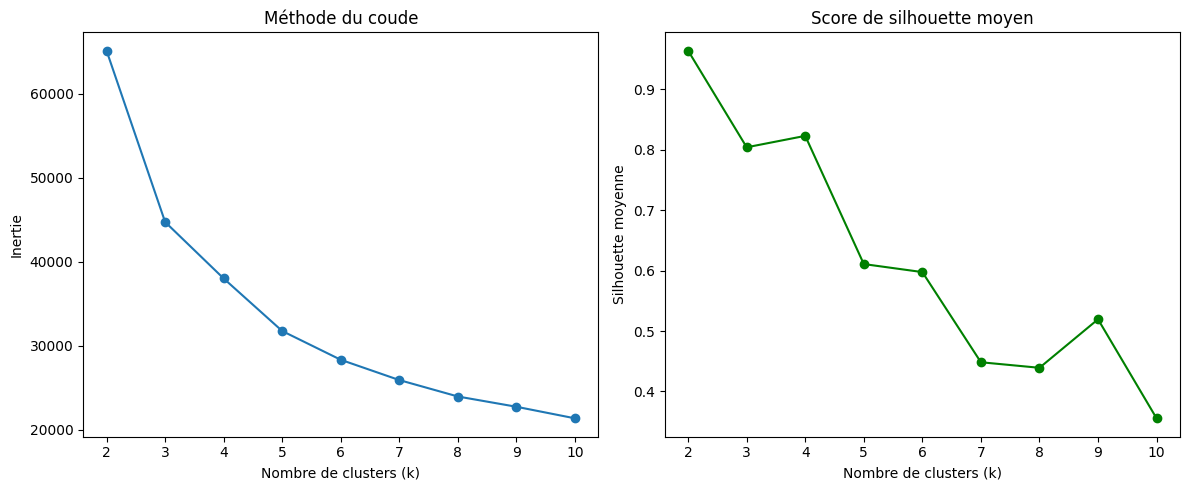

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
import numpy as np

# Tester plusieurs valeurs de k
range_k = range(2, 11)
inertias = []
silhouette_avgs = []

print("Calcul des inerties et scores de silhouette pour différentes valeurs de k...")

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(data_scaled, labels)
    silhouette_avgs.append(silhouette_avg)
    print(f"k={k} → silhouette moyenne = {silhouette_avg:.3f}")

# Méthode du coude (inertie)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range_k, inertias, marker='o')
plt.title("Méthode du coude")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")

# Silhouette moyenne
plt.subplot(1, 2, 2)
plt.plot(range_k, silhouette_avgs, marker='o', color='green')
plt.title("Score de silhouette moyen")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette moyenne")

plt.tight_layout()
plt.show()


In [14]:
def visualize_silhouette(data_scaled, k):
    """
    Visualisation détaillée des silhouettes pour un k donné
    """
    print(f"\nAnalyse détaillée des silhouettes pour k={k}...")
    
    # Créer un nouveau clusterer avec le k optimal
    clusterer = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(data_scaled)
    
    # Silhouette moyenne pour tous les échantillons
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    print(f"Score de silhouette moyen pour k={k}: {silhouette_avg:.3f}")
    
    # Calculer les valeurs de silhouette pour chaque échantillon
    sample_silhouette_values = silhouette_samples(data_scaled, cluster_labels)
    
    # Visualisation
    plt.figure(figsize=(12, 8))
    
    y_lower = 10
    for i in range(k):
        # Agréger les scores de silhouette pour les échantillons du cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        # Étiqueter les clusters de silhouette
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Calculer le nouveau y_lower pour le prochain plot
        y_lower = y_upper + 10
    
    plt.title(f"Visualisation détaillée de la silhouette pour k={k}", fontsize=16)
    plt.xlabel("Scores de silhouette", fontsize=14)
    plt.ylabel("Cluster", fontsize=14)
    
    # La ligne verticale pour le score de silhouette moyen
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.grid(True, alpha=0.3)
    plt.show()


Analyse détaillée des silhouettes pour k=6...
Score de silhouette moyen pour k=6: 0.597


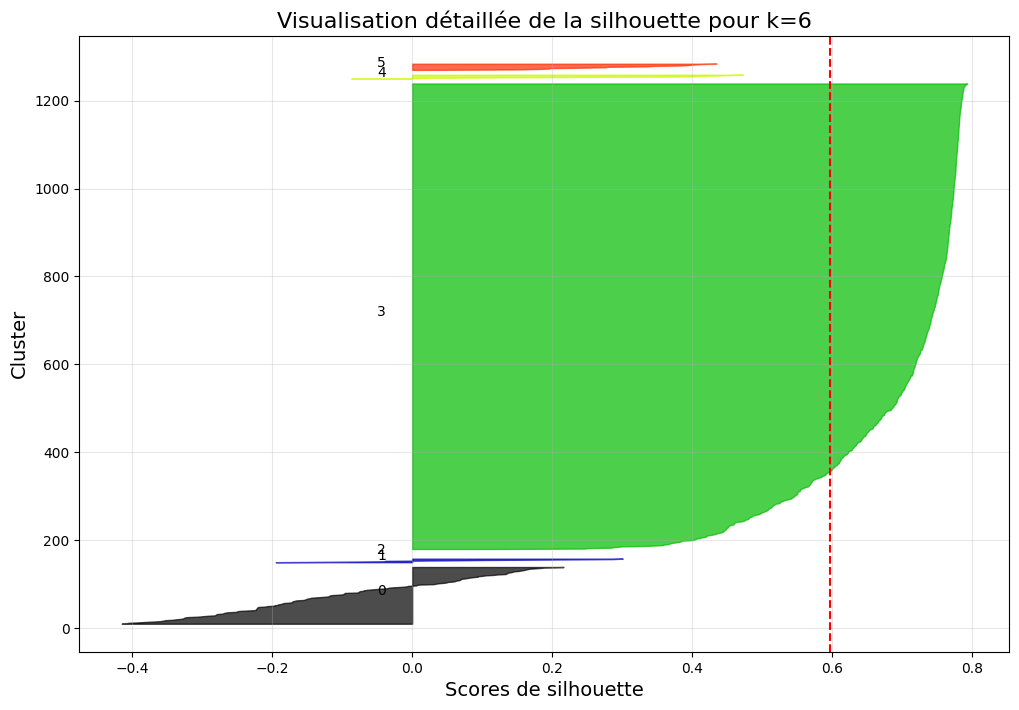

In [28]:
visualize_silhouette(data_scaled, k=6)


In [34]:
epci_features_2['geometry'] = epci_features_2['geometry'].apply(convert_if_string)
epci_features_2 = gpd.GeoDataFrame(epci_features_2, geometry='geometry')

/tmp/ipykernel_65317/2278616265.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_clusters)


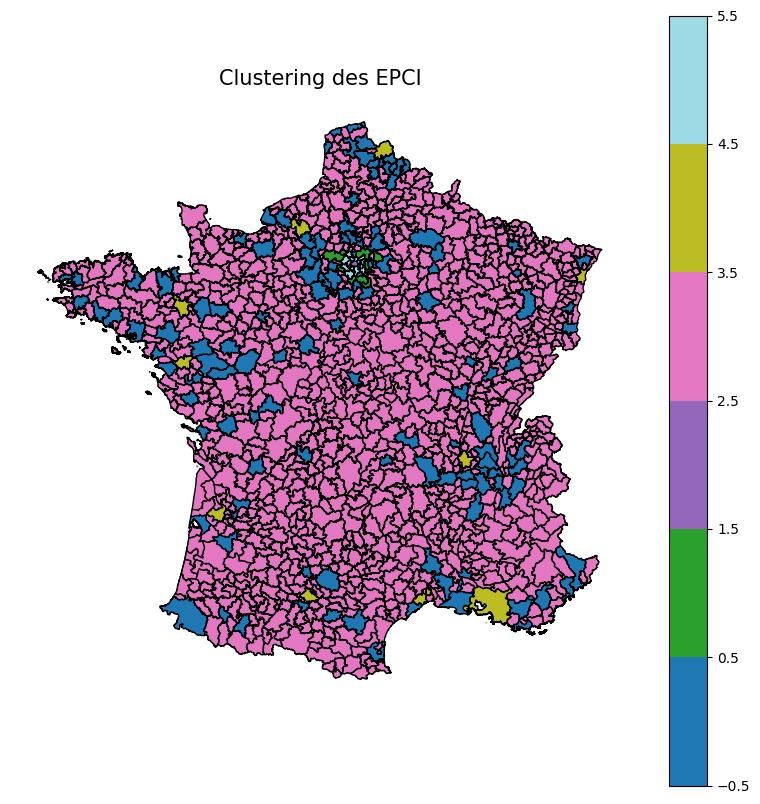

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import BoundaryNorm

# Identifier le nombre de clusters et créer une liste de valeurs uniques triées
clusters_uniques = sorted(epci_features_2['cluster'].unique())
n_clusters = len(clusters_uniques)

# Créer des limites pour la normalisation des couleurs
bounds = np.arange(min(clusters_uniques), max(clusters_uniques) + 2) - 0.5
norm = BoundaryNorm(bounds, n_clusters)

# Obtenir une colormap avec le bon nombre de couleurs
cmap = plt.cm.get_cmap('tab20', n_clusters)

# Tracer la carte avec le cmap personnalisé et la normalisation
fig, ax = plt.subplots(figsize=(10, 10))
epci_features_2.plot(column='cluster', cmap=cmap, norm=norm, legend=True, edgecolor="black", ax=ax)

# Personnalisation
ax.set_title("Clustering des EPCI", fontsize=15)
ax.axis("off")
plt.show()

In [36]:
var = epci_features_2.columns.tolist()

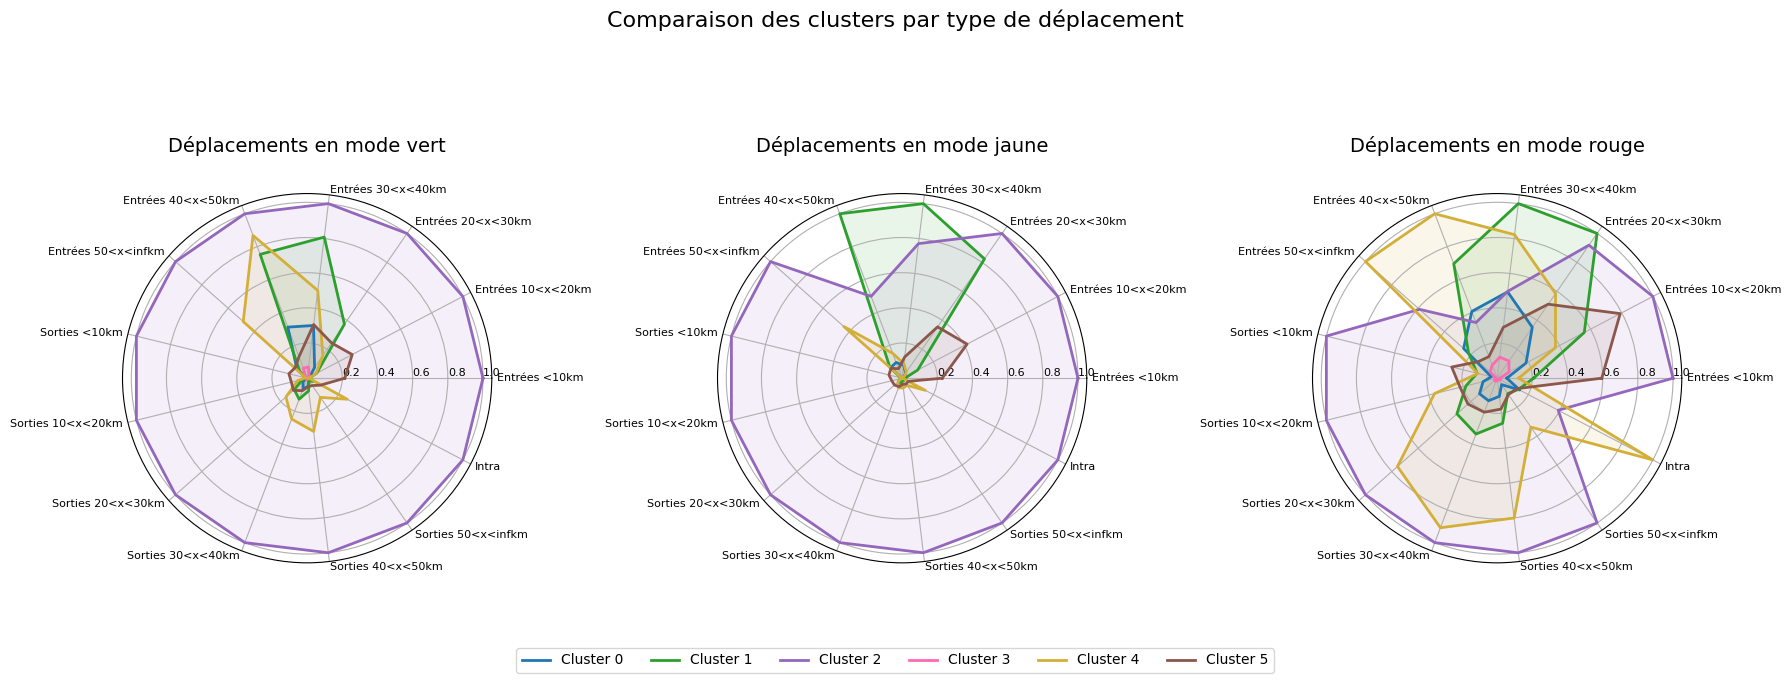

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_chart(fig, titles, data, colors, subplot_pos):
    N = len(titles)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]
    data = np.array([d.tolist() + [d[0]] for d in data])
    ax = fig.add_subplot(subplot_pos, polar=True)

    # Tracé des lignes
    for i, d in enumerate(data):
        ax.plot(angles, d, color=colors[i], linewidth=2, label=f'Cluster {i}')
        ax.fill(angles, d, color=colors[i], alpha=0.1)

    # Étiquettes : en horizontal, sans retour ligne
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])  # Suppression des étiquettes auto

    for label, angle in zip(titles, angles[:-1]):
        angle_deg = np.degrees(angle)
        x = np.cos(angle)
        y = np.sin(angle)
        ha = 'center'
        if angle_deg < 90 or angle_deg > 270:
            ha = 'left'
        elif 90 < angle_deg < 270:
            ha = 'right'
        ax.text(angle, 1.08, label, ha=ha, va='center', fontsize=8, rotation=0)

    # Y-axis
    ax.set_rlabel_position(0)
    ax.set_rticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)
    ax.grid(True)
    return ax


# Utiliser les données du DataFrame existant
df = epci_features_2  # Votre DataFrame existant

# Définir les modes et distances
modes = ['vert', 'jaune', 'rouge']
distances = ['<10km', '10<x<20km', '20<x<30km', '30<x<40km', '40<x<50km', '50<x<infkm']

# Calculer les moyennes par cluster pour chaque attribut
def aggregate_metrics(df, mode):
    metrics = []
    labels = []
    
    # Calculer les entrées totales par distance pour chaque mode
    for dist in distances:
        col_name = f'nb_entrant_{dist}_{mode}'
        if col_name in df.columns:
            metric_name = f'Entrées {dist}'
            df_grouped = df.groupby('cluster')[col_name].mean()
            metrics.append(df_grouped)
            labels.append(metric_name)
    
    # Calculer les sorties totales par distance pour chaque mode
    for dist in distances:
        col_name = f'nb_sortant_{dist}_{mode}'
        if col_name in df.columns:
            metric_name = f'Sorties {dist}'
            df_grouped = df.groupby('cluster')[col_name].mean()
            metrics.append(df_grouped)
            labels.append(metric_name)
    
    # Ajouter les trajets internes
    col_name = f'nb_intra_{mode}'
    if col_name in df.columns:
        metric_name = f'Intra'
        df_grouped = df.groupby('cluster')[col_name].mean()
        metrics.append(df_grouped)
        labels.append(metric_name)
    
    # Combiner toutes les métriques
    combined = pd.concat(metrics, axis=1)
    combined.columns = labels
    
    # Normaliser pour le radar chart
    normalized = combined / combined.max()
    
    return normalized, labels

# Couleurs correspondant à la carte de France selon la légende
# La légende indique des valeurs de 0.5 à 4.5, donc 6 clusters (0, 1, 2, 3, 4, 5)
cluster_colors = [
    '#1f77b4',  # Bleu pour cluster 0 (0.5 sur la carte)
    '#2ca02c',  # Vert pour cluster 1 (1.5 sur la carte)
    '#9467bd',  # Violet pour cluster 2 (2.5 sur la carte)
    '#ff69b4',  # Rose pour cluster 3 (3.5 sur la carte)
    '#d4af37',  # Jaune/Or pour cluster 4 (4.5 sur la carte)
    '#8c564b',  # Brun pour cluster 5
]

# Créer un graphique par couleur
fig = plt.figure(figsize=(18, 10))
plt.subplots_adjust(top=0.90, bottom=0.15)  # Ajuster l'espace pour le titre et la légende

# Ajouter un titre principal plus près des graphiques
fig.suptitle('Comparaison des clusters par type de déplacement', fontsize=16, y=0.85)

# Radar pour les déplacements verts
green_data, green_labels = aggregate_metrics(df, 'vert')
ax1 = radar_chart(fig, green_labels, green_data.values, cluster_colors, 131)
ax1.set_title('Déplacements en mode vert', size=14,pad=30)

# Radar pour les déplacements jaunes
yellow_data, yellow_labels = aggregate_metrics(df, 'jaune')
ax2 = radar_chart(fig, yellow_labels, yellow_data.values, cluster_colors, 132)
ax2.set_title('Déplacements en mode jaune', size=14,pad=30)

# Radar pour les déplacements rouges
red_data, red_labels = aggregate_metrics(df, 'rouge')
ax3 = radar_chart(fig, red_labels, red_data.values, cluster_colors, 133)
ax3.set_title('Déplacements en mode rouge', size=14,pad=30)

# Légende globale plus haute sur la figure
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, 0.18))

plt.tight_layout(rect=[0, 0.07, 1, 0.93])  # Ajuster la mise en page en tenant compte de la légende et du titre
plt.show()

🟩 Variables discriminantes en mode vert

En mobilité douce (mode vert), les variables les plus différenciantes sont :

Entrées 50<x<infkm : Très forte valeur pour le cluster 2, quasi-nulle ailleurs.
Intra : Montre une forte polarisation sur certains clusters.
Sorties 10<x<20km et Sorties 20<x<30km : Bien que globalement faibles, ces distances moyennes distinguent quelques clusters intermédiaires.
Les flux verts sont donc peu fréquents à longue distance, ce qui renforce l'importance de variables comme Intra pour saisir l'ancrage local de ces pratiques.

🟨 Variables discriminantes en mode jaune

En mode "jaune" (mobilité moyenne, probablement automobile locale ou navette), on observe que :

Entrées 40<x<50km et Entrées 50<x<infkm sont extrêmement différenciantes, notamment pour les clusters 1 et 2.
Intra et Sorties <10km montrent aussi des variations significatives.
Ce mode met en évidence des disparités claires dans l’échelle des mobilités, révélant des territoires soit à fort rayonnement régional, soit à usage très localisé.

🟥 Variables discriminantes en mode rouge

Le mode "rouge" (probablement motorisé longue distance ou pendulaire) illustre clairement des effets de polarisation :

Les Entrées longues distances (>30km) sont les plus discriminantes, avec des pics très nets dans certains clusters (notamment les clusters 1, 2 et 4).
Sorties 50<x<infkm : également très marquée pour certains profils.
Intra conserve un pouvoir discriminant.
Ce mode met en lumière les territoires à haute intensité de déplacement sortant longue distance, en lien probable avec les dynamiques périurbaines ou métropolitaines.

🚫 Variables peu utiles au clustering

Certaines variables s’avèrent faiblement différenciantes, car elles présentent des valeurs proches entre tous les clusters :

Sorties <10km et Sorties 10<x<20km en mode vert :
Faibles valeurs homogènes entre clusters → peu informatives.
Entrées <10km tous modes :
Très faible dispersion, donc faible pouvoir de segmentation.
Sorties 20<x<30km en mode rouge :
Bien qu'en théorie importante, la variance observée est trop faible.
Ces variables, en étant quasi constantes ou uniformément basses, n’apportent pas d'information structurante dans la classification.